# Packages & Imports

In [ ]:
!python -m pip install pandas
!python -m pip install numpy
!python -m pip install matplotlib
!python -m pip install opencv-python opencv-python-headless
!python -m pip install opencv-contrib-python
!python -m pip install scipy
!python -m pip install scikit-learn

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import stats
from sklearn.cluster import DBSCAN

## Data set

In [6]:
# reading the 04-05 data from the csv
df = pd.read_csv('dataset/Solar_flare_RHESSI_2004_05.csv')

# verify by checking the last 5 rows of the data (year/month should be 2005, 24)
df.tail()

,duration.s,peak.c/s,total.counts,energy.kev,x.pos.asec,y.pos.asec,radial,active.region.ar,flag.1,flag.2,...,flag.4,flag.5,dt.start,dt.peak,dt.end,year,month,day,energy.kev.i,energy.kev.f
17501,704,24,72312.0,6-12,-279,229,362,841,A0,DF,...,P1,Q2,2005-12-29 21:38:40,2005-12-29 21:39:50,2005-12-29 21:50:24,2005,12,29,6,12
17502,212,22,24624.0,6-12,-402,238,468,841,A0,DF,...,Q1,NaN,2005-12-29 22:07:16,2005-12-29 22:08:18,2005-12-29 22:10:48,2005,12,29,6,12
17503,584,184,332976.0,6-12,-251,243,350,843,A0,GD,...,GS,P1 PE Q4,2005-12-30 16:47:04,2005-12-30 16:50:02,2005-12-30 16:56:48,2005,12,30,6,12
17504,512,56,101424.0,6-12,-250,228,339,0,A0,P1,...,Q1,NaN,2005-12-30 20:18:20,2005-12-30 20:21:22,2005-12-30 20:26:52,2005,12,30,6,12
17505,292,18,25416.0,6-12,879,-216,906,844,A0,DF,...,Q1,NaN,2005-12-30 21:49:12,2005-12-30 21:49:30,2005-12-30 21:54:04,2005,12,30,6,12


## Design and implement a hotspot discovery algorithm 

In [18]:
epsilon = 200
min_samples = 5

def hotspot_detection(d1, d2, df):
    # Create an intensity map from x and y positions
    intensity_map = df[['x.pos.asec', 'y.pos.asec', 'total.counts']].values

    # Initialize DBSCAN with appropriate eps (neighborhood size) based on d1 or d2
    dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)

    # Fit DBSCAN on the intensity map
    dbscan.fit(intensity_map)

    # Get cluster labels and hotspots
    cluster_labels = dbscan.labels_
    hotspot_indices = (cluster_labels >= 0)  # Filter out noise (label -1)

    # Separate data points into hotspots and noise
    hotspots = intensity_map[hotspot_indices]
    noise = intensity_map[~hotspot_indices]

    # Create a scatter plot
    plt.figure(figsize=(10, 8))

    # Separate data into d1 and d2 hotspots based on energy.kev.f
    d1_hotspots = hotspots[df['total.counts'][hotspot_indices] >= d1]
    d2_hotspots = hotspots[df['total.counts'][hotspot_indices] >= d2]
    
    # Plot noise in purple
    plt.scatter(noise[:, 0], noise[:, 1], c='purple', marker='x', label='Noise')

    # Plot d2 hotspots in green
    plt.scatter(d2_hotspots[:, 0], d2_hotspots[:, 1], c='green', marker='o', label=f'd2 Hotspots (>= {d2})')

    # Plot d1 hotspots in red
    plt.scatter(d1_hotspots[:, 0], d1_hotspots[:, 1], c='red', marker='o', label=f'd1 Hotspots (>= {d1})')

    plt.xlabel('X Position (asec)')
    plt.ylabel('Y Position (asec)')
    plt.title('Hotspot Detection')
    plt.legend()
    plt.grid(True)

    plt.show()




## Determine intensity threshold d1 and d2 for Method1, based on your results for Task1 

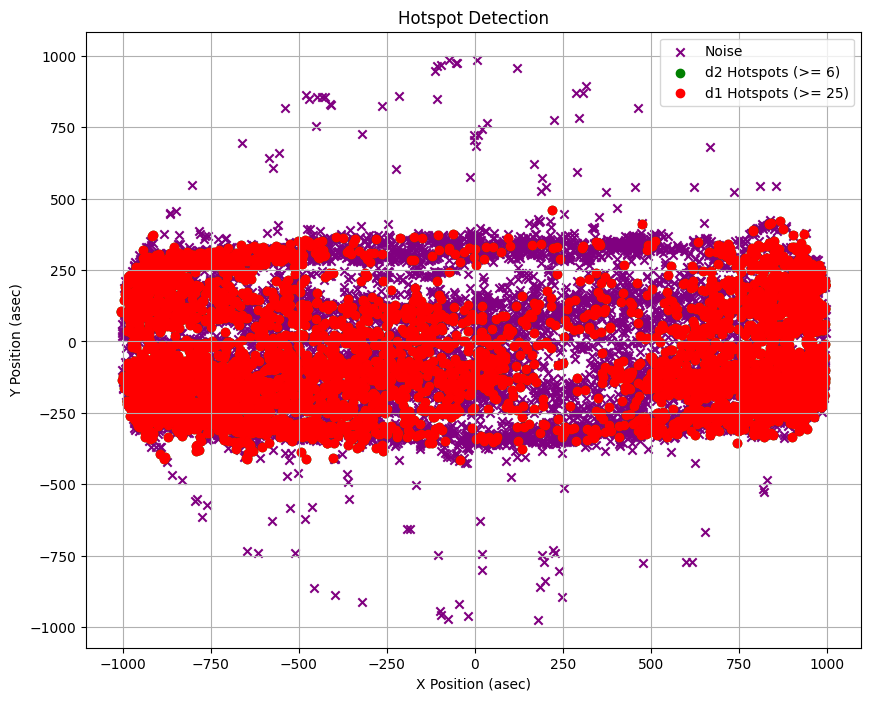

Number of points greater than d1: 17505
Number of points greater than d2: 17506


In [19]:
d1 = 25
d2 = 6

hotspot_detection(d1, d2, df)

print(f'Number of points greater than d1: {len(df[df["total.counts"] > d1])}')
print(f'Number of points greater than d2: {len(df[df["total.counts"] > d2])}')


## Create a method to visualize hotspots